# Coursera Capstone Project - IBM Data Science Specialization
## Project Title

Analysis of St. Louis City neighborhoods based on data related to demographic, crime and places of interest.

Table of contents
* [Introduction](#Introduction) 
* [Data](#Data)
* [Methodology](#Methodology)
* [Results](#Results)
* [Discussion](#Discussion)
* [Conclusion](#Conclusion)



### Introduction

St. Louis is a midwestestern city in the state of Missouri. It has a population of around 350,000 with the city divided into 79 neighborhoods. The goal of this project is to gather, explore and apply machine learning techniques in order to cluster these neighborhoods according to similarities. Specifically we will be looking at places of interest in a neighborhood (data provided by FourSquare API), as well as crime rate in the city(data provided by St. Louis Metropolitan Police Department). The result of the analysis is targeted towards city dwellers and business owners who can make informed decisions when it comes to their day to day life in the city.

### Data
The data for this project is being gathered from three main sources and will be combined together for final exploration and analysis :
* WikiPedia article about neighborhoods of St. Louis and their demographic data
* St. Louis Metropolitan Police Department 2018 Crime Data
* FourSquare API for gathering venues given neighborhood coordinates

The data sourced from these places are combined and analyzed in following manner:
Wikipedia's article provides neighborhood names. These names will be used to get longitude and latitude information. After some correlating of data between Police Dept data and Wikipedia, a merged view will be created where crime and demographic data can be seen together. Finally, based on coordinates of the neighborhood calculated before, Foursquare API will be used to source venues of interest which will become main input for clustering.

### Methodology
This section describes in detail the the steps performed to extract meaningful information from the data sources mentioned above.

#### 1. Data Extraction and cleaning from wikipedia and geopy API.
As with any data science project working with data, the first step was to import necessary python packages and define constants which will be used afterwards.

In [3]:
#import the packages
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import requests
import folium
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import os
import math
from os import listdir
from os.path import isfile, join
import matplotlib as mlt
import matplotlib.pyplot as plt
#define constants
BASE_URL = 'https://api.foursquare.com/v2'
CLIENT_ID = ''
CLIENT_SECRET = ''
wikiUrl = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_of_St._Louis'
V='20180604'

Once packages were imported next step is to fetch the Wikipedia article and extract the table with relevant data. Python package Beautifulsoup and requests were used for it.

In [50]:
#Fetch Wikipedia article
resp = requests.get(wikiUrl)
html_text = resp.text

In [51]:
#Parse and build data frame
soup = BeautifulSoup(html_text, 'html.parser')
neighborhood_table = soup.find_all('table')[1]
rows = neighborhood_table.find_all('tr')
header = []
for th in rows[0].find_all('th'):
    header.append(th.text.replace('\n',''))
df_neighborhood = pd.DataFrame(columns = header)
rows = rows[1:]
rownum  = 0
for row in rows:
    df_row = []
    for td in row.find_all('td'):
        df_row.append(td.text.replace('\n',''))
    #print(df_row)
    df_neighborhood.loc[rownum] = df_row
    rownum = rownum + 1


The dataframe built has following columns -
* Neighborhood
* Population
* White population %
* Black population %
* Hispanic/Latino2 population %
* AIAN1 population %
* Asian population %
* Mixed Race population %
* Corridor

The sample data extract is as shown below:

In [52]:
df_neighborhood.head()

,Neighborhood,Population,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,Corridor
0,Academy,"3,006",16.9,54.7,20.5,1.52,4.3,3.5,North
1,Baden,"7,268",6.3,91.8,0.5,0.1,0,1.3,North
2,Benton Park,"3,532",68.2,25.1,3.2,0.3,1.2,3.8,South
3,Benton Park West,"4,404",28.0,59.6,10.5,0,1.9,5.1,South
4,Bevo Mill,"12,654",74.2,13.8,7.5,0.4,4.6,3.9,South


#### Extraction of longitude and latitude data and appending to the dataframe
Next step was to use the neighborhood data to extract longitude and latitude information and append it to the dataframe. For this GeoPy was used. The GeoPy Data is noisy and missing data for 22 neighborhoods. The code and output below shows list of neighborhoods where no data was found.

In [53]:
geolocator = Nominatim(user_agent='stl_data_analysis', format_string="%s, St. Louis Missouri")
df_coords = pd.DataFrame(columns = ['Neighborhood','Latitude', 'Longitude'])
#df_neighborhood.set_index('Neighborhood', inplace = True)
#df_neighborhood.head()
row_num = 0
for entry in df_neighborhood['Neighborhood']:
     #print('Getting entry for {}'.format(entry))
     data = geolocator.geocode(entry)
     if data != None:
         address, (latitude, longitude) = data
         df_coords.loc[row_num] = [entry,latitude,longitude]
         #print(entry,address, latitude, longitude)
     else:
         print('Not found for entry - {}'.format(entry))
         #df_coords.loc[row_num] = [entry,99.99,99.99]
     row_num =row_num+1
df_coords.shape

Not found for entry - Clayton-Tamm
Not found for entry - College Hill
Not found for entry - Downtown West
Not found for entry - The Gate District
Not found for entry - Grand Center
Not found for entry - Hamilton Heights
Not found for entry - JeffVanderLou
Not found for entry - Kings Oak
Not found for entry - Lafayette Square
Not found for entry - LaSalle Park
Not found for entry - Marine Villa
Not found for entry - Mark Twain
Not found for entry - Mark Twain/I-70 Industrial
Not found for entry - McKinley Heights
Not found for entry - Mount Pleasant
Not found for entry - North Hampton
Not found for entry - Old North St. Louis
Not found for entry - Peabody Darst Webbe
Not found for entry - Princeton Heights
Not found for entry - South Hampton
Not found for entry - Southwest Garden
Not found for entry - Wydown/Skinker


(57, 3)

In [54]:
df_merged = df_neighborhood
df_merged = df_merged.join(df_coords.set_index('Neighborhood'), on='Neighborhood')
df_merged.shape

(79, 11)

The data collected so far was written to a CSV file for further processing.

In [55]:
df_merged.to_csv('df_merged.csv')

### Manual Data cleaning
For the neighbourhoods where geopy geolocator could not find the coordinates, manual Google search was done to get the coordinates. After the Goole search 2 out of 79 neighborhoods (`The Gate District`,`Peabody Darst Webbe`) didn't have results in google. For these two random coordinates were taken from related geojson file. Once the cleanup was done the final CSV was read from disk for further analysis and processing. The sample data is shown as below:

In [56]:
df_merged = pd.read_csv('df_merged_final.csv')

In [57]:
df_merged.drop(df_merged.columns[0], axis=1, inplace = True)
df_merged.head()

,Neighborhood,Population,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,Corridor,Latitude,Longitude
0,Academy,"3,006",16.9,54.7,20.5,1.52,4.3,3.5,North,38.659025,-90.267293
1,Baden,"7,268",6.3,91.8,0.5,0.10,0.0,1.3,North,38.709732,-90.230831
2,Benton Park,"3,532",68.2,25.1,3.2,0.30,1.2,3.8,South,38.597383,-90.222621
3,Benton Park West,"4,404",28.0,59.6,10.5,0.00,1.9,5.1,South,38.597383,-90.222621
4,Bevo Mill,"12,654",74.2,13.8,7.5,0.40,4.6,3.9,South,38.581723,-90.266955


#### Plotting the neighbourhoods on map using geojson and Folium
To verify that the coordinates and neighborhood data covers whole of St. Louis, the data was plotted on a map using Folium. Minor adjustments had to be done to couple of areas to match dataframe and geojson files.
The output is as shown below. The data mostly seem accurate except couple of coordinates where center of neighborhoods seem off, and one of the neighborhood entry is completely missing from the geojson. For the scope of this project, it was decided that we can tolerate these anomalies.

In [58]:
# Get log/lat of St. Louis
address_stl = 'St. Louis, US'
geolocator_stl = Nominatim(user_agent="stl_explorer")
location = geolocator_stl.geocode(address_stl)
latitude = location.latitude
longitude = location.longitude
#print('The geograpical coordinate of St. Louis are {}, {}.'.format(latitude, longitude))

In [59]:
map_stl = folium.Map(location=[latitude, longitude], zoom_start=12)
geo_json = os.path.join('.','st-louis.geojson')
# add markers to map
    
folium.GeoJson(
    geo_json,
    name='geojson'
).add_to(map_stl)    

for lat, lng, neighborhood in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_stl)

map_stl

### 2. St. Louis Crime Data Extraction
#### St. Louis Police Department ID to Neighborhood mapping
St. Louis Crime Report data (available at this [link](https://www.slmpd.org/Crimereports.shtml)) has `Neighborhood` as numeric value. They have a reference sheet in [FAQ](http://www.slmpd.org/Crime/CrimeDataFrequentlyAskedQuestions.pdf) document which lists ID to Neighborhood mapping. The next step in this project is to load the mapping from this document, join with `df_merged` and clean any data which is missing/different.The detail of steps can be seen in the code section below.

In [60]:
#Load the ID to Neighborhood mapping
df_id_mapping = pd.read_csv('Id_to_Neighbourhood_Mapping.csv')

# join with df_merged on neighborhood column
df_new = df_merged.join(df_id_mapping.set_index('Neighborhood'), on='Neighborhood')

#Rows where data is still missing
df_new[df_new['Neighborhood_ID'].isnull()]
missing_neighborhood_ids= {
    'Botanical Heights':28,
    'Carondelet': 1,
    'Fairground':83,
    'Forest Park Southeast':39,
    'Grand Center':77,
    'Greater Ville':56,
    'Hi-Pointe':44,
    'JeffVanderLou':59,
    'LaSalle Park':34,
    'Mark Twain/I-70 Industrial':70,
    'Near North Riverfront':64,
    'O\'Fallon':85,
    'Wells/Goodfellow':50,
    'Wydown/Skinker':45
}

len(missing_neighborhood_ids)
for key,value in missing_neighborhood_ids.items():
    #print('{},{}'.format(key,value))
    df_new.loc[df_new.Neighborhood == key,'Neighborhood_ID' ] = value
df_merged = df_new
df_merged.shape

(79, 12)

In [61]:
df_for_dict = df_merged[['Neighborhood_ID','Neighborhood']]
df_for_dict.set_index('Neighborhood_ID', inplace = True)
dfmerged_dict = df_for_dict.to_dict().get('Neighborhood')
len(dfmerged_dict)

79

#### St. Louis City Crime data for the year 2018
For the year of 2018, crime data was obtained from St. Louis Metro Police Dept [website](https://www.slmpd.org/Crimereports.shtml). In total there were 46,742 crimes of various categories. We will get into details of it as we go.
Monthly crime records were downloaded and are available in Github in crime_records folder.
These will be verified for shape and mergeability into a single dataset.

In [62]:
#initialize merged_crime_df with columns
JanCSV = pd.read_csv('./crime_records/January2018.CSV')
# read the dir crime_records for CSVs and merge into a single dataframe.
merged_crime_df = pd.DataFrame(columns=JanCSV.columns.values)
mypath = './crime_records/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for f in onlyfiles:
    file_df = pd.read_csv('{}{}'.format(mypath,f))
    merged_crime_df = merged_crime_df.append(file_df)
    #print(merged_crime_df.shape)
merged_crime_df.shape

(46742, 20)

#### So far we have following data frames -
* `df_merged` - Neighborhood data with long/lat, demographics and NeighborhoodIds
* `merged_crime_df` - 2018 Crime Data, not grouped by neighbourhood yet.
* The next step will be collect neighborhood data from foursquare API.

### Exploratory Data Analysis of St. Louis Crime Data
But before that we should perform exploratory data analysis of crime vs neighborhood for St. Louis and show the results in a choropleth map. The crime dataframe was joined and updated with Neighborhood names so that descriptive data can be presented while visualizing the data in tabular format and in the maps. The table below shows data in tabular format after this processing.


In [63]:
df_merged = df_merged.astype({'Neighborhood_ID':'int64'})
merged_crime_df = merged_crime_df.astype({'Neighborhood':'int64'})
merged_crime_df.Neighborhood = merged_crime_df.Neighborhood.map(lambda x :dfmerged_dict.get(x,x) )
df_crime_stl_grped = merged_crime_df.groupby('Neighborhood').count().sort_values(by='Count',ascending=False)
df_crime_stl_grped.reset_index(inplace=True)
df_crime_stl_grped.head()


,Neighborhood,Complaint,CodedMonth,DateOccur,FlagCrime,FlagUnfounded,FlagAdministrative,Count,FlagCleanup,Crime,District,Description,ILEADSAddress,ILEADSStreet,LocationName,LocationComment,CADAddress,CADStreet,XCoord,YCoord
0,Downtown,3457,3457,3457,3457,3457,3457,3457,3457,3457,3457,3457,3457,3457,3450,3457,3457,3457,3457,3457
1,Dutchtown,2402,2402,2402,2402,2402,2402,2402,2402,2402,2402,2402,2402,2402,2401,2402,2402,2402,2402,2402
2,Central West End,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062
3,Downtown West,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866
4,Carondelet,1605,1605,1605,1605,1605,1605,1605,1605,1605,1605,1605,1605,1605,1605,1605,1605,1605,1605,1605


This data was plotted on a choropleth map to show the crime statistics of various neighborhoods in graphic way.
Below map can be used to see various neighborhood and their crime statistics.In the final map of this project this data will be combined with venue data to represent a unified picture of classification.

In [64]:
map_stl = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='OpenStreetMap')
geo_json = os.path.join('.','st-louis.geojson')
# add markers to map
    
# folium.GeoJson(
#     geo_json,
#     name='geojson'
# ).add_to(map_stl)    

map_stl.choropleth(
    geo_data=geo_json,
    data=df_crime_stl_grped,
    columns=['Neighborhood', 'Count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='St. louis crime stats'
)

for lat, lng, neighborhood in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_stl)

map_stl

### Population vs Crime relation
It is expected that higher the population, more number of crimes there are. Here we will validate/examine the assumption by plotting a scatter plot between independent variable population and dependent variable crime.

In [65]:
df_temp = df_crime_stl_grped[['Neighborhood', 'Count']]
df_temp = df_temp.rename(columns={'Count':'CrimeCount'})
df_temp.dtypes
df_merged.dtypes
#df_temp = df_temp.astype({'Neighborhood':'object'})

df_merged=  df_merged.merge(df_temp,on='Neighborhood')



In [66]:
df_merged.Population = df_merged.Population.map(lambda x :x.replace(',','') )
df_merged.Population = df_merged.Population.map(lambda x :int(x) )


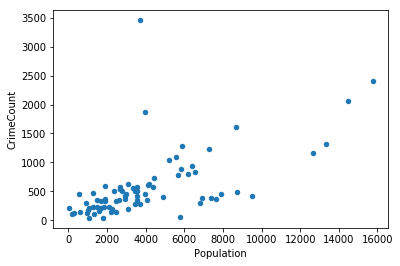

In [67]:
df_merged.plot(kind = 'scatter', x = 'Population', y ='CrimeCount')
plt.show()

While it is evident that number of crimes in general linearly related to population; there are some outliers which show interesting fact that there are some 
neighborhoods where number of crime is too high compared to the population. Sorting the data by number of crimes; it an be seen that Downtown lies in this category where population 
is low compared to number of crimes reported on yearly basis.The last column in this table is the crime count while second column is population.Please note while the crime count is from year 2018, population figures are from 2010 census. However we do not expect a significant change in this pattern as overall population of St. Louis has not changed drastically in recent years.

In [68]:
df_merged.sort_values(by='CrimeCount', ascending=False).head()

,Neighborhood,Population,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,Corridor,Latitude,Longitude,Neighborhood_ID,CrimeCount
17,Downtown,3721,53.5,37.1,2.9,0.5,5.4,2.3,Central,38.622710,-90.190710,35,3457
19,Dutchtown,15770,35.6,50.8,9.0,0.3,6.0,3.8,South,38.580353,-90.240832,16,2402
9,Central West End,14473,58.0,28.0,2.7,0.2,11.1,2.2,Central,38.635999,-90.262513,38,2062
18,Downtown West,3940,56.3,36.9,2.6,0.3,3.7,2.9,Central,38.629200,-90.208000,36,1866
7,Carondelet,8661,57.3,33.8,7.1,0.6,1.3,3.7,South,38.556164,-90.265947,1,1605


### 3. Venues data for location from foursquare
FourSquare is being used in this project to extract neighbourhood venues of interest based on latitude and longitude of neighborhoods. The number of venues for each service call to foursquare was limited to 100. Unlike the projects in coursera, there was no radius parameter specified while making service call. This way, the radius parameter is automatically determined by foursquare API based on density of data for any neighborhood.Below are the steps in brief that were performed and how the data was transformed to analysis by K-Means clustering algorithm.

#### Extract Location data for single neighborhood:
In this step neighborhood data for very first neighborhood was extracted and validated for correctness.

In [69]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [70]:
neighborhood_latitude = df_merged.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_merged.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_merged.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Academy are 38.6590245, -90.2672934111736.


In [95]:
url =  '{}/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&limit=100&radius=5000'.format(BASE_URL,CLIENT_ID,CLIENT_SECRET,neighborhood_latitude,neighborhood_longitude, V)
print(url)


https://api.foursquare.com/v2/venues/explore?client_id=&client_secret=&ll=38.6590245,-90.2672934111736&v=20180604&limit=100&radius=5000


In [72]:
results = requests.get(url).json()

In [73]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.shape

(100, 4)

#### Repeat for all neighborhood of St. Louis
Here we repeated the steps for all 79 neighborhoods and extracted the data in dataframe `stl_venues` for further processing

In [74]:
LIMIT =100
radius = 5000
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            V, 
            lat, 
            lng, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [75]:
stl_venues = getNearbyVenues(names=df_merged['Neighborhood'],
                                   latitudes=df_merged['Latitude'],
                                   longitudes=df_merged['Longitude']
                                 )

Academy
Baden
Benton Park
Benton Park West
Bevo Mill
Botanical Heights
Boulevard Heights
Carondelet
Carr Square
Central West End
Cheltenham
Clayton-Tamm
Clifton Heights
College Hill
Columbus Square
Compton Heights
DeBaliviere Place
Downtown
Downtown West
Dutchtown
Ellendale
Fairground
Forest Park Southeast
Fountain Park
Fox Park
Franz Park
The Gate District
Grand Center
Gravois Park
Greater Ville
Hamilton Heights
The Hill
Hi-Pointe
Holly Hills
Hyde Park
JeffVanderLou
Kings Oak
Kingsway East
Kingsway West
Kosciusko
Lafayette Square
LaSalle Park
Lewis Place
Lindenwood Park
Marine Villa
Mark Twain
Mark Twain/I-70 Industrial
McKinley Heights
Midtown
Mount Pleasant
Near North Riverfront
North Hampton
North Point
North Riverfront
O'Fallon
Old North St. Louis
Patch
Peabody-Darst-Webbe
Penrose
Princeton Heights
Riverview
Shaw
Skinker-DeBaliviere
Soulard
South Hampton
Southwest Garden
St. Louis Hills
St. Louis Place
Tiffany
Tower Grove East
Tower Grove South
Vandeventer
The Ville
Visitation Par

The table below shows sample of extracted data from stl_venues dataframe.

In [76]:
#stl_venues.groupby('Neighborhood').count() 
stl_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Academy,38.659025,-90.267293,Third Degree Glass Factory,38.651953,-90.270579,Factory
1,Academy,38.659025,-90.267293,Dressel's Pub,38.649086,-90.260987,Gastropub
2,Academy,38.659025,-90.267293,Left Bank Books,38.648360,-90.260969,Bookstore
3,Academy,38.659025,-90.267293,Pi Pizzeria,38.648414,-90.260911,Pizza Place
4,Academy,38.659025,-90.267293,Jeni's Splendid Ice Creams,38.648150,-90.261064,Ice Cream Shop


#### One hot encoding
Similar to Toronote/New York analysis, one-hot encoding was applied to the dataframe to prepare the data to fit using K-Means algorithm. The modified dataframe had a dimension of 214 attributes. That's the number of categories for which FourSquare API returned data. Sample data for this transformed dataframe is as shown below.

In [77]:
# one hot encoding
stl_onehot = pd.get_dummies(stl_venues[['Venue Category']], prefix="", prefix_sep="")
#stl_onehot.drop(['Neighborhood'], axis=1, inplace=True)
# add neighborhood column back to dataframe
stl_onehot['Neighborhood'] = stl_venues['Neighborhood'] 

fixed_columns = [stl_onehot.columns[-1]] + list(stl_onehot.columns[:-1])
stl_onehot = stl_onehot[fixed_columns]

stl_onehot = stl_onehot[fixed_columns]



In [78]:
stl_grouped = stl_onehot.groupby('Neighborhood').mean().reset_index()
stl_grouped
stl_grouped.head()

,Neighborhood,ATM,Accessories Store,Advertising Agency,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Volleyball Court,Waste Facility,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,Academy,0.0,0.01,0.0,0.050000,0.0,0.00,0.01,0.0,0.00,...,0.0,0.0,0.0,0.02,0.01,0.0,0.000000,0.01,0.00,0.0
1,Baden,0.0,0.00,0.0,0.028571,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.00,0.00,0.0,0.014286,0.00,0.00,0.0
2,Benton Park,0.0,0.00,0.0,0.020000,0.0,0.00,0.01,0.0,0.00,...,0.0,0.0,0.0,0.01,0.00,0.0,0.000000,0.00,0.00,0.0
3,Benton Park West,0.0,0.00,0.0,0.020000,0.0,0.00,0.01,0.0,0.00,...,0.0,0.0,0.0,0.01,0.00,0.0,0.000000,0.00,0.00,0.0
4,Bevo Mill,0.0,0.00,0.0,0.030000,0.0,0.01,0.00,0.0,0.01,...,0.0,0.0,0.0,0.00,0.00,0.0,0.010000,0.00,0.01,0.0


In [91]:
# num_top_venues = 5

# for hood in stl_grouped['Neighborhood']:
#     #print("----"+hood+"----")
#     temp = stl_grouped[stl_grouped['Neighborhood'] == hood].T.reset_index()
#     temp.columns = ['venue','freq']
#     temp = temp.iloc[1:]
#     temp['freq'] = temp['freq'].astype(float)
#     temp = temp.round({'freq': 2})
#     print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#     print('\n')

In [80]:
### Most Common value function
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most common venues for each neighborhood
Functions were created to visualize most common category for each neighborhood.This was done by sorting features for each neighborhood according to their frequency as shown in previous table and then taking out top 10 of those and show it in table as displayed below.

In [81]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = stl_grouped['Neighborhood']

for ind in np.arange(stl_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stl_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Academy,Coffee Shop,American Restaurant,Pizza Place,Cocktail Bar,Italian Restaurant,Bar,Dessert Shop,Gym,Grocery Store,Burger Joint
1,Baden,Fast Food Restaurant,Discount Store,Chinese Restaurant,Pharmacy,Sandwich Place,Convenience Store,Gas Station,Grocery Store,Diner,Park
2,Benton Park,Bar,Coffee Shop,Pizza Place,Restaurant,Brewery,Mexican Restaurant,Breakfast Spot,Bakery,Park,BBQ Joint
3,Benton Park West,Bar,Coffee Shop,Pizza Place,Restaurant,Brewery,Mexican Restaurant,Breakfast Spot,Bakery,Park,BBQ Joint
4,Bevo Mill,Bar,Pizza Place,Mexican Restaurant,Pub,Vietnamese Restaurant,Chinese Restaurant,American Restaurant,Convenience Store,Coffee Shop,Fast Food Restaurant
5,Botanical Heights,Coffee Shop,Bar,Sandwich Place,Garden,Wine Bar,Café,Brewery,Middle Eastern Restaurant,New American Restaurant,Mediterranean Restaurant
6,Boulevard Heights,Pizza Place,Bar,Mexican Restaurant,Video Store,Gym,Fast Food Restaurant,Brewery,Park,BBQ Joint,Chinese Restaurant
7,Carondelet,Pizza Place,Bar,Mexican Restaurant,Park,Chinese Restaurant,Bakery,Grocery Store,Coffee Shop,BBQ Joint,Convenience Store
8,Carr Square,Coffee Shop,American Restaurant,Hotel,Bar,BBQ Joint,Mediterranean Restaurant,Sandwich Place,Food Truck,Hockey Arena,Sushi Restaurant
9,Central West End,Pizza Place,Bar,Coffee Shop,New American Restaurant,Ice Cream Shop,American Restaurant,Science Museum,Gym,Indian Restaurant,Southern / Soul Food Restaurant


### 4. Cluster Neighborhoods with K-Means Algorithms
After some analysis(described in section 5), it was decided to use `hyperparameter` of `6` for k-means clustering. The higher number of cluster was chosen based on the fact that we did not see a sharp drop in elbow method of analysis. The Silhouette score was also best for k = 6, even though it didn't have an optimum value of >0.5. More details of this analysis can be found section 5. The cluster labels for neighborhoods and sample data with Cluster Label attached can be seen below.

In [82]:
#hyperparameter number of clusters

kclusters = 6
stl_grouped_clustering = stl_grouped.drop('Neighborhood', 1)
stl_grouped_clustering.head()
# # run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(stl_grouped_clustering)

# # # check cluster labels generated for each row in the dataframe
kmeans.labels_

array([5, 0, 2, 2, 1, 2, 1, 1, 4, 5, 3, 3, 1, 5, 4, 2, 3, 4, 4, 2, 1, 5,
       3, 5, 2, 3, 5, 2, 5, 5, 3, 1, 5, 5, 3, 5, 5, 2, 4, 4, 5, 1, 2, 0,
       5, 2, 5, 2, 4, 1, 4, 0, 5, 4, 1, 4, 4, 1, 0, 2, 3, 2, 1, 1, 1, 4,
       2, 4, 5, 2, 2, 2, 5, 5, 0, 0, 5, 5, 3], dtype=int32)

In [83]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5,Academy,Coffee Shop,American Restaurant,Pizza Place,Cocktail Bar,Italian Restaurant,Bar,Dessert Shop,Gym,Grocery Store,Burger Joint
1,0,Baden,Fast Food Restaurant,Discount Store,Chinese Restaurant,Pharmacy,Sandwich Place,Convenience Store,Gas Station,Grocery Store,Diner,Park
2,2,Benton Park,Bar,Coffee Shop,Pizza Place,Restaurant,Brewery,Mexican Restaurant,Breakfast Spot,Bakery,Park,BBQ Joint
3,2,Benton Park West,Bar,Coffee Shop,Pizza Place,Restaurant,Brewery,Mexican Restaurant,Breakfast Spot,Bakery,Park,BBQ Joint
4,1,Bevo Mill,Bar,Pizza Place,Mexican Restaurant,Pub,Vietnamese Restaurant,Chinese Restaurant,American Restaurant,Convenience Store,Coffee Shop,Fast Food Restaurant


In [84]:
#Merge with df_merged or crime_merged to get the coordinates labels together.
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
df_merged.head() # check the last columns!

Finally the cluster label data was joined together with master merged data to present a unified view as shown below.
This view has all the parameters of interest to us -
* Name of neighborhood
* Population Distribution.
* Crime statistics
* Coordinates
* Cluster Labels
* 10 most common categories of interest

,Neighborhood,Population,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,Corridor,Latitude,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Academy,3006,16.9,54.7,20.5,1.52,4.3,3.5,North,38.659025,...,Coffee Shop,American Restaurant,Pizza Place,Cocktail Bar,Italian Restaurant,Bar,Dessert Shop,Gym,Grocery Store,Burger Joint
1,Baden,7268,6.3,91.8,0.5,0.10,0.0,1.3,North,38.709732,...,Fast Food Restaurant,Discount Store,Chinese Restaurant,Pharmacy,Sandwich Place,Convenience Store,Gas Station,Grocery Store,Diner,Park
2,Benton Park,3532,68.2,25.1,3.2,0.30,1.2,3.8,South,38.597383,...,Bar,Coffee Shop,Pizza Place,Restaurant,Brewery,Mexican Restaurant,Breakfast Spot,Bakery,Park,BBQ Joint
3,Benton Park West,4404,28.0,59.6,10.5,0.00,1.9,5.1,South,38.597383,...,Bar,Coffee Shop,Pizza Place,Restaurant,Brewery,Mexican Restaurant,Breakfast Spot,Bakery,Park,BBQ Joint
4,Bevo Mill,12654,74.2,13.8,7.5,0.40,4.6,3.9,South,38.581723,...,Bar,Pizza Place,Mexican Restaurant,Pub,Vietnamese Restaurant,Chinese Restaurant,American Restaurant,Convenience Store,Coffee Shop,Fast Food Restaurant


### Neighborhood map with cluster label, Name, Crime Count and its analysis.
We prepared data for visualizing on map with cluster labels, Crime count, and top two places of interest categories. The below interactive map can be browsed to go over this data. We retained the choropleth map from before to classify neighborhood in two fashions.
* Based on crime rate the color of Choropleth map classifies Downtown and Dutchtown as similar (high crime).
* Based on cluster labeling which is calculated based on venue data, they have different labels - 4 for downtown, and 2 for Dutchtown.
This gives user ability to analyze the data further to find out similar neighborhood.
It's also observed that the algorithm is clustering neighborhood together based on their geographic proximity. For example all the neighborhood near Forest Park are being classified together with label 3 with Zoo being most important feature that distinguish them from rest of neighborhoods.

It's also observed that as expected prominent place of interest around downtown areas are Hotels and Bars.In a setup like downtown this is to be expected.

In [90]:
map_stl = folium.Map(location=[latitude, longitude], zoom_start=12)
color_labels = ['blue','green','yellow','orange','pink','black']
# add markers to map
map_stl.choropleth(
    geo_data=geo_json,
    data=df_merged,
    columns=['Neighborhood', 'CrimeCount'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='St. louis crime stats')

for lat, lng, neighborhood,clusterlabel, CrimeCount, most_common,sec_most_common in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'],df_merged['Cluster Labels'], df_merged['CrimeCount'],df_merged['1st Most Common Venue'],df_merged['2nd Most Common Venue']  ):
    label = 'Name: {} <br> Label: {} <br> Crime Count: {}, <br> Most Common: {},{}'.format(neighborhood, str(clusterlabel), str(CrimeCount),most_common,sec_most_common )
    label = folium.Html(label, script = True)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= 'black' if math.isnan(clusterlabel) else color_labels[int(clusterlabel)],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_stl)  


map_stl

/anaconda3/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### 5. Finding Optimal K for K-Means algorithm
As K is considered hyperparameter, Elbow Method and Silhouette Score was used to determine value which will help the most with this dataset.As shown below, I did not see a significant drop when using Elbow method to correct specify which number will be best suited.Based on Silhouette Score of 0.25 and the fact that after that drop in elbow method was low, the value of k = 6 was chosen. The Elbow method and Silhouette Score charts are as show below

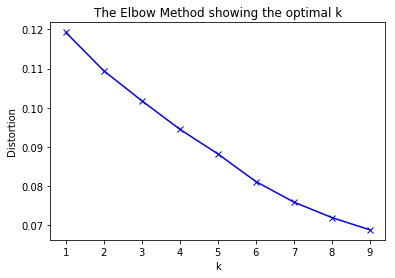

In [87]:
from scipy.spatial.distance import cdist

distortions = []

K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(stl_grouped_clustering)
    #kmeanModel.fit(stl_grouped_clustering)
    distortions.append(sum(np.min(cdist(stl_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / stl_grouped_clustering.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [88]:
#silhouette_score for the cluster with K=6
from sklearn.metrics import silhouette_score
silhouette_score(stl_grouped_clustering,kmeans.labels_)
stl_grouped_clustering.iloc[:, 3].unique()

array([0.05      , 0.02857143, 0.02      , 0.03      , 0.01      ,
       0.04      , 0.06      , 0.07      , 0.03448276, 0.01333333,
       0.        , 0.01428571])

For n_clusters = 2 The average silhouette_score is : 0.24223665762134983
For n_clusters = 3 The average silhouette_score is : 0.17353634871225374
For n_clusters = 4 The average silhouette_score is : 0.19790352020070542
For n_clusters = 5 The average silhouette_score is : 0.21227686983418423
For n_clusters = 6 The average silhouette_score is : 0.250689163603189
For n_clusters = 8 The average silhouette_score is : 0.2941163537277409


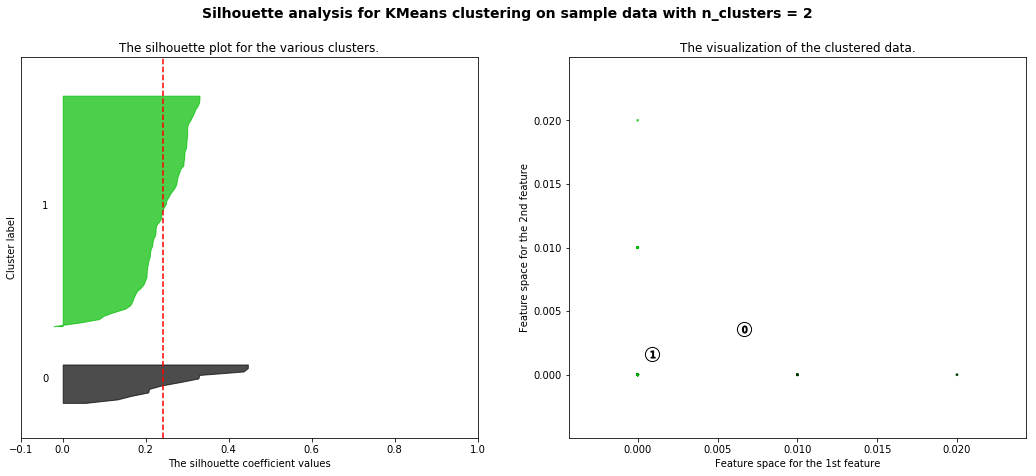

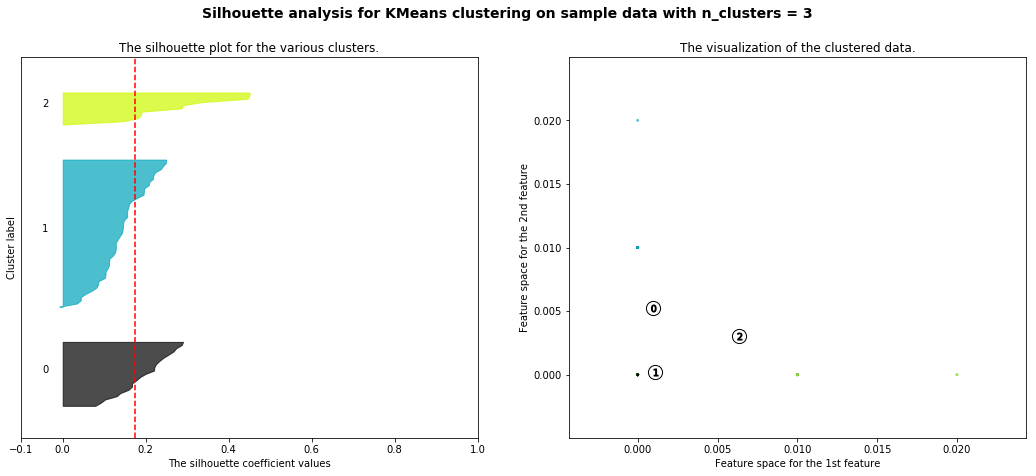

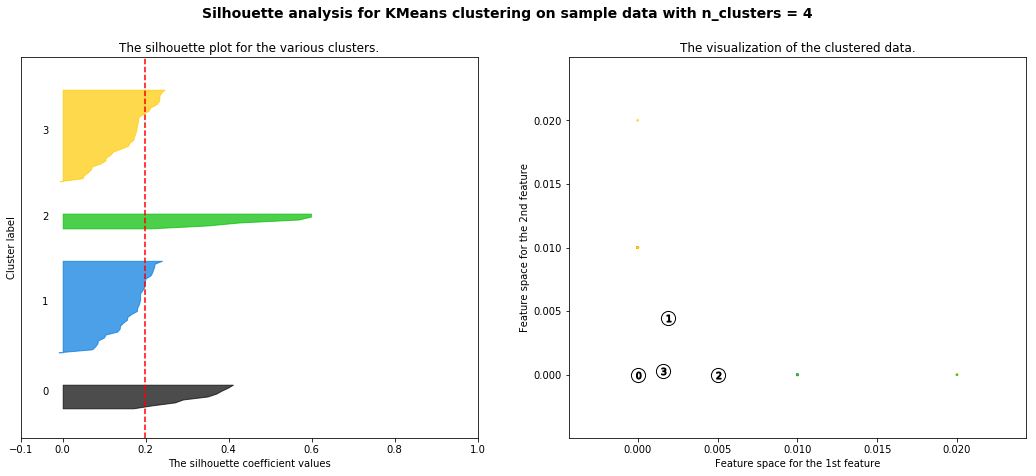

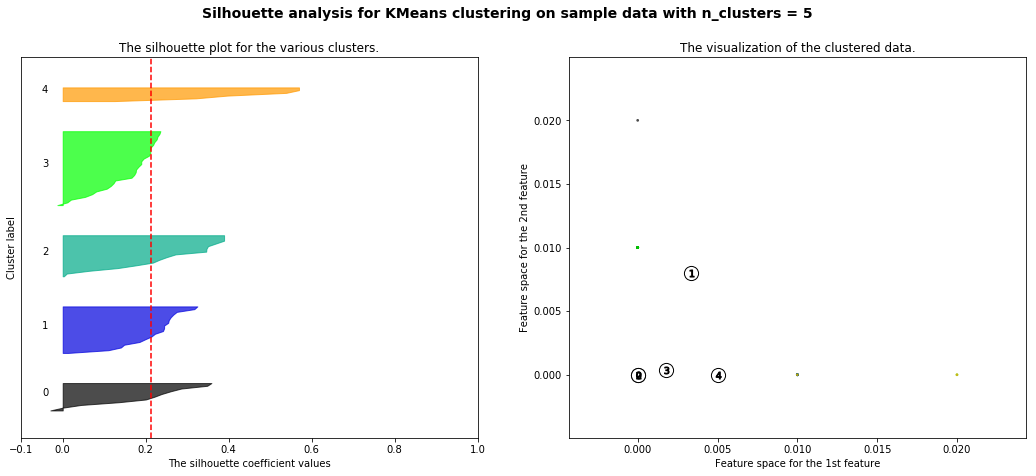

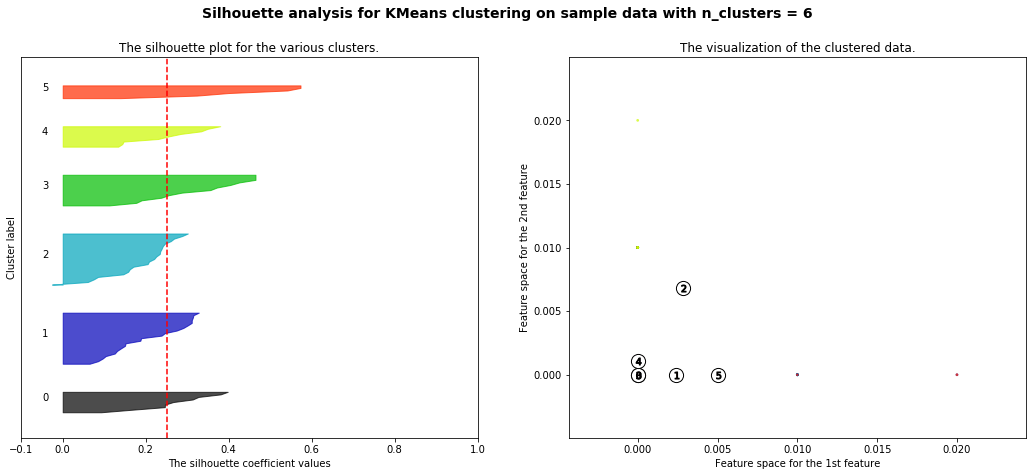

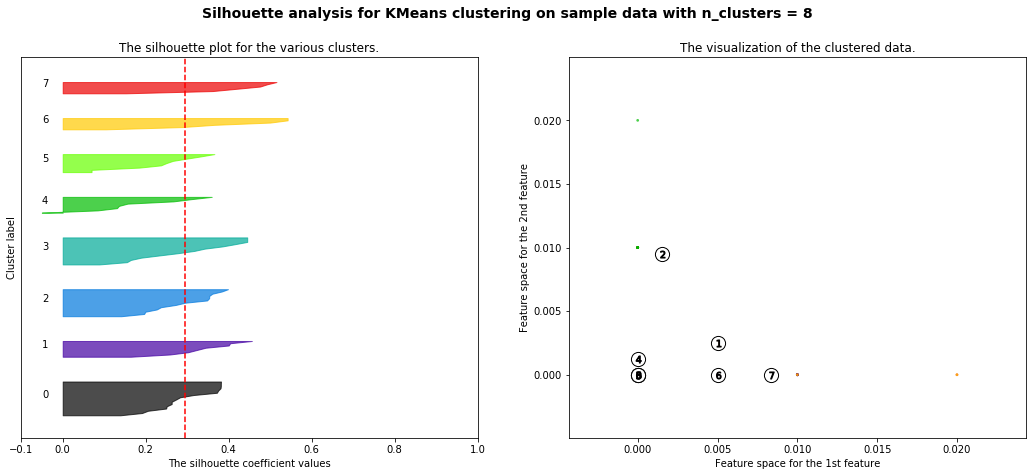

In [89]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
X = stl_grouped_clustering

range_n_clusters = [2, 3, 4, 5, 6,8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    clusterer.fit(X)
    cluster_labels = clusterer.labels_
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 4], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

### Results
Based on analysis of the data we can summarize that St. Louis with population of ~350,000 people is a closely clustered city. The neighborhoods are comparatively small when compared to bigger cities such as New York. The places of interest classify the neighborhood into same cluster based on their geographical proximity. The crime data sheds an important light on the fact that Downtown even with smaller population size remains one of the most crime prone area. Dutchtown with comparatively higher population comes second when it comes to crime rate. Central West End which is classified as label 5(Bar,Restaurant) is one of the largest neighborhood and upcoming district where Cortex Innovation Center is located. Unfortunately this area is also high when it comes to number of crimes.

### Discussion
The foursquare data itself seem insufficient for most accurate clustering of cities. Data such has crime rate, median house prices, taxes, business revenue will be of further interest to refine the model further for classification. Unfortunately not all of such data is available in public domain to do such an effort. But the knowledge gained here will be good starting point to perform such an analysis further.

### Conclusion
Overall I found this project to be very interesting. After Capstone completion, I intend to further work on it to add more data points as I discover them. There is a effort going on currently to merge St. Louis county and City together known as Better Together. I intend to perform some analysis related to that based on knowledge gained in this project in order to predict if such a measure will be beneficial to the community.

### Credit
Much of the work/code in this project is based on learning from [IBM Data Science specialization](https://www.coursera.org/specializations/ibm-data-science-professional-certificate?) offered on Coursera. I would like to thank team at IBM for coming up with such an amazing introductory course on Data Science.